# 2. Grouping customers together!

In [6]:
# importing required packages
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime as dt
import matplotlib.pyplot as plt

## 2.1 Getting your data + feature engineering

In [7]:
# reading data
data = pd.read_csv('bank_transactions.csv', delimiter = ',')
# renaming TransactionAmount (INR) column
data.rename(columns = {"TransactionAmount (INR)":"TransactionAmount_INR"}, inplace = True)

In [8]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount_INR'],
      dtype='object')

#### Formatting DateTime

In [9]:
# cleaning data
# dropping na, reformatting date times

data.dropna(inplace=True)#? doesnt change
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) 
data.TransactionDate = pd.to_datetime(data.TransactionDate) 
data.TransactionTime = data.TransactionTime.apply(lambda x: dt.strptime(str(x).zfill(6), '%H%M%S').time() )

#### Offset the people born after 2000 and drop the Customer born before 1900

In [10]:
data_cop = data.copy()
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year < 1900].index, axis=0, inplace=True)

We reformat the data to remove some unnatural occurences of dates of births (DOB). The CustomerIDs with a DOB in 1800 are dropped. DOBs over 2000 are set off by 100 years. The modified data seems more natural.

Text(0.5, 1.0, 'CustomerDOB modified')

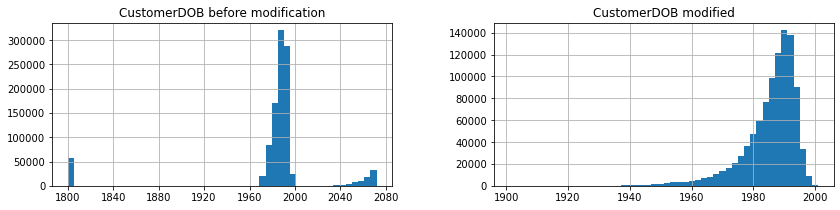

In [11]:
fig, ax = plt.subplots(1,2, figsize = (14, 3))

hist = data_cop.hist(column='CustomerDOB', bins = 50, ax = ax[0])
ax[0].set_title('CustomerDOB before modification')
hist2 = data.hist(column='CustomerDOB', bins = 50, ax = ax[1])
ax[1].set_title('CustomerDOB modified')

### Number of transaction per CustomerID

In [22]:
# nr_trans 
nr_trans = data[['CustomerID','TransactionID']].groupby(by = 'CustomerID').count()
nr_trans.rename(columns = {'TransactionID' : 'nr_trans'}, inplace = True)

### Number of transaction that have a value larger than 100

In [23]:
# nr of transactions that exceed 100 INR
nr_trans_greater_100 = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
nr_trans_greater_100.rename(columns = {'TransactionAmount_INR' : 'trans_greater_100'}, inplace = True)

### Mean of transactions for each customer

In [14]:
#  mean_trans 
mean_trans = data[['CustomerID','TransactionAmount_INR']].groupby(by='CustomerID').mean()
mean_trans.rename(columns = {'TransactionAmount_INR':'mean_trans' }, inplace = True)

### Mean of total Balance for each customerID

In [15]:
# mean_balance
mean_balance = data[['CustomerID','CustAccountBalance']].groupby(by='CustomerID').mean()
mean_balance.rename(columns = {'CustAccountBalance':'mean_balance' }, inplace = True)

### Mean difference between the mean balance and the mean transaction

In [16]:
#mean_diff. Aka Utilization
mean_diff = pd.DataFrame( mean_balance.mean_balance.sub(mean_trans.mean_trans, axis = 0) )
mean_diff.columns = ['mean_diff']

### Most frequent gender for each customerID

In [17]:
gender_most_freq = data.groupby(by = 'CustomerID').apply(lambda x: x['CustGender'].value_counts().index[0])
gender_most_freq = pd.DataFrame(gender_most_freq)
gender_most_freq.columns = ['gender_most_freq']
# converting 'M' to 1 and 'F' to 0
gender_most_freq['gender_most_freq'] = gender_most_freq['gender_most_freq'].apply(lambda x: 1 if x=='M' else 0)

### Most frequent location 

In [18]:
# most_freq_loc new
most_freq_loc = data.groupby(by='CustomerID').apply(lambda x: x['CustLocation'].value_counts().index[0])
most_freq_loc = pd.DataFrame(most_freq_loc)
most_freq_loc.columns = [ 'most_freq_loc']

### Merge all the 7 features into one df

In [24]:
# merging nr_trans and nr_trans_greater_100 separately to ensure correct format
nr_trans_and_nr_greater_100 = nr_trans.merge(nr_trans_greater_100, on= 'CustomerID', how='left').fillna(0)
# all the dfs to be concatenated
dfs = [nr_trans_and_nr_greater_100, mean_trans, mean_balance, mean_diff, gender_most_freq, most_freq_loc]

df_7 = pd.concat(dfs, 1)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_41930/3440457736.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_7 = pd.concat(dfs, 1)


In [26]:
# saving for later usage
df_7.to_csv('seven_params_3.csv', sep=',', encoding='utf-8', index = False)

## 20 features

In [22]:
def findMinMaxTrans(data) -> pd.DataFrame:
    return data.groupby("CustomerID").agg(  min_trans = ("TransactionAmount_INR", min),
                                            max_trans = ("TransactionAmount_INR", max),
                                            )

In [36]:
def findQuant(data, quant) -> pd.DataFrame:
    df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
    return df.rename(columns = {'TransactionAmount_INR':f'{quant}_quant_trans' })

In [47]:
def findTransValueVar(data) -> pd.DataFrame:
    var =  data.groupby('CustomerID').apply(lambda group: group['TransactionAmount_INR'].nunique()/len(group['TransactionAmount_INR']))
    return pd.DataFrame(var).rename(columns={'TransactionAmount_INR':'trans_val_var'})

In [53]:
def findMinMaxDiffBalance(data) -> pd.DataFrame:
    df =  data.groupby("CustomerID").agg(  min_balance = ("CustAccountBalance", min),
                                            max_balance = ("CustAccountBalance", max),
                                            )
    df['diff_balance'] =  df.max_balance.sub(df.min_balance, axis = 0)
    return df

In [80]:

def findTransactionTimes(data) -> pd.DataFrame:
    hours_data = data[['CustomerID', 'TransactionTime']]
    hours_data['TransactionTime'] = pd.to_datetime((hours_data['TransactionTime']).astype(str)).dt.hour
    mean_hour = hours_data.groupby(by = 'CustomerID').mean()
    max_hour = hours_data.groupby(by = 'CustomerID').max()
    min_hour = hours_data.groupby(by = 'CustomerID').min()
    most_freq_hour = hours_data.groupby(by = 'CustomerID')['TransactionTime'].apply(lambda x: x.value_counts().index[0])
    most_freq_hour = pd.DataFrame(most_freq_hour)

    df = pd.concat([mean_hour, max_hour, min_hour, most_freq_hour], 1)
    df.columns = ['mean_hour', 'max_hour', 'min_hour', 'most_freq_hour']

    return df

In [165]:
def findTransactionDate(data) -> pd.DataFrame:
    dates = data[['CustomerID', 'TransactionDate']]
    #dates['dt'] = pd.to_datetime(dates.TransactionDate.astype(str))
    most_freq_weekday = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.weekday.value_counts().index[0])
    most_freq_month = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.value_counts().index[0])
    nr_diff_months = dates.groupby(by = 'CustomerID').apply(lambda group: group.TransactionDate.dt.month.nunique())

    frame = {'most_freq_weekday': most_freq_weekday, 'most_freq_month': most_freq_month, 'nr_diff_months': nr_diff_months}
    df = pd.DataFrame(frame)
    return df

In [112]:
def findNrLocs(data) -> pd.DataFrame:
    df =  pd.DataFrame(data.groupby(by = 'CustomerID')['CustLocation'].nunique())
    df.columns = ['nr_diff_locs']
    return df

In [113]:
def findNrDOB(data) -> pd.DataFrame:
    df = pd.DataFrame(data.groupby(by = 'CustomerID')['CustomerDOB'].nunique())
    df.columns = ['nr_diff_dob']
    return df

In [206]:
def findMeanAge(data):
    df = data[['CustomerID', 'TransactionDate', 'CustomerDOB']].groupby(by = 'CustomerID').apply(lambda group: (group.TransactionDate-group.CustomerDOB ).astype('timedelta64[Y]').mean() )# might have to select in data already
    df = pd.DataFrame(df)
    df.columns = ['mean_age_trans']
    return df

In [171]:
def findNrTrans1K(data) -> pd.DataFrame:
    df = data[['CustomerID','TransactionAmount_INR']].query("TransactionAmount_INR > 100").groupby(by= "CustomerID").count()
    df.columns = ['trans_greater_1k']
    return df

In [141]:
def findNrBalance100K(data) -> pd.DataFrame:
    df = data[['CustomerID','CustAccountBalance']].query("CustAccountBalance > 100").groupby(by= "CustomerID").count()
    df.columns = ['balance_greater_100k']
    return df

In [198]:
def findTrans_ValBalRatio(data) -> pd.DataFrame:
    mean_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).mean())
    max_ratio = data.groupby(by = 'CustomerID').apply(lambda group: (group.TransactionAmount_INR / group.CustAccountBalance).min())
    frame = {'mean_ratio': mean_ratio, 'max_ratio': max_ratio}
    df = pd.DataFrame(frame)
    return df

In [207]:
def features_20(data): 
    
    #min and max of transaction for each customerID
    min_max_trans = findMinMaxTrans(data)
    #quantiles of transactions for each customerID
    quant_75_trans = findQuant(data, 0.75)
    quant_25_trans = findQuant(data, 0.25)
    # ratio of unique transactions amounts for customerID
    trans_val_var = findTransValueVar(data)
    
    #min and max of balance for each customerID
    min_max_diff_balance = findMinMaxDiffBalance(data)
    
    # get max_hour, min_hour, mean_hour and most frequent hour of transactions for customerID
    transaction_times = findTransactionTimes(data)
    
    # get most frequent weekdy, most frequent month, and number of differnt months for transactions done by the customerID
    transaction_dates = findTransactionDate(data)
    
    # number of different locations from which a customerID has made transactions
    nr_diff_locs = findNrLocs(data)
    
    # nr of unique dates of birth for customerID, might roughly be the number of people using the account
    nr_diff_dob = findNrDOB(data) 
    
    # mean age of customerID at times of transaction (in years)
    age_mean = findMeanAge(data)
    
    # number transactions that exceed 1000 INR
    nr_trans_1k = findNrTrans1K(data) # dimension!
    
    # number transaction instances at which the customer balance was > 100000
    nr_balance_100k = findNrBalance100K(data)
    
    # transaction amount/balance ratio , return the mean and max of this ratio
    trans_valbalratio = findTrans_ValBalRatio(data)

    # merging dataframes with different dimensionality separately
    pre_df = min_max_trans.merge(nr_trans_1k, on = 'CustomerID', how = 'left').fillna(0)
    pre_df = pre_df.merge(nr_balance_100k, on = 'CustomerID', how = 'left').fillna(0)

    df_all = pd.concat([pre_df, quant_75_trans, quant_25_trans, trans_val_var, min_max_diff_balance, transaction_times, transaction_dates, 
                        nr_diff_locs, nr_diff_dob, age_mean, trans_valbalratio], 1)
    
    return df_all    

    # these were originally included:
    #avg_nr_trans_perday = group.groupby(by= 'TransactionDate').count().mean()
    #first_freq_loc = group['CustLocation'].agg(lambda x:x.value_counts().index[0])
    #std_balance = group['CustAccountBalance'].std()
    

In [173]:
# calling the function features_20() for the data 'bank_transactions.csv'
data_20 = features_20(data)

/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/457625945.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df = data.groupby('CustomerID')[['CustomerID','TransactionAmount_INR']].quantile(quant)
/var/folders/c0/1q90pl8n3k50gnjpfmzf_lzh0000gn/T/ipykernel_3943/1643579581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [26]:
data_20.head()

,CustomerID,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,...,min_hour,most_freq_hour,most_freq_weekday,most_freq_month,nr_diff_months,nr_diff_locs,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio
0,C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,...,1,12,0,9,1,2,2,28.0,0.074556,0.002962
1,C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,...,20,20,6,8,1,1,1,22.0,0.061931,0.061931
2,C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,...,15,15,4,1,2,1,2,27.0,0.016472,0.001545
3,C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,...,17,17,3,9,1,1,1,26.0,0.060462,0.060462
4,C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,...,14,14,3,8,1,1,1,51.0,0.057433,0.057433


In [203]:
# storing for later usage
data_20.to_csv('twenty_params_2.csv', sep = ',', encoding = 'utf-8')

# 2.2 Choose your features (variables)!

#### loading the data and packages

In [27]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from datetime import datetime as dt


import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix


In [28]:
# loading dataframes and concatenating
data_20 = pd.read_csv('twenty_params_2.csv', delimiter = ',') 
data_7 = pd.read_csv('seven_params_3.csv', delimiter = ',').reset_index(drop=True)
data_27 = pd.concat([data_20, data_7], axis = 1) # forming one dataframe of 27 features
data_27.set_index('CustomerID', inplace = True)

In [29]:
data_27.fillna(0, inplace = True) # fill NA cells with 0
data_27.replace([np.inf, -np.inf], 0, inplace=True) # replace inf values with 0

In [30]:
cols_for_norm = data_27.columns[0:28] # for now selecting column names with numerical values
data_num = data_27[cols_for_norm] # forming new dataframe with only numerical parameters
data_num.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,trans_greater_100,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,356.0,4750.0,2.0,2.0,3651.50,1454.50,1.0,32500.73,120180.54,87679.81,...,2,28.0,0.074556,0.002962,2,2.0,2553.0,76340.635,73787.635,0
C1010012,1499.0,1499.0,1.0,1.0,1499.00,1499.00,1.0,24204.49,24204.49,0.00,...,1,22.0,0.061931,0.061931,1,1.0,1499.0,24204.490,22705.490,1
C1010014,250.0,1205.0,2.0,2.0,966.25,488.75,1.0,38377.14,161848.76,123471.62,...,2,27.0,0.016472,0.001545,2,2.0,727.5,100112.950,99385.450,0
C1010018,30.0,30.0,0.0,1.0,30.00,30.00,1.0,496.18,496.18,0.00,...,1,26.0,0.060462,0.060462,1,0.0,30.0,496.180,466.180,0
C1010024,5000.0,5000.0,1.0,1.0,5000.00,5000.00,1.0,87058.65,87058.65,0.00,...,1,51.0,0.057433,0.057433,1,1.0,5000.0,87058.650,82058.650,1


## 2.2 Choose your features (variables)!

### Data Normalization
The initial data contains both continuous and discrete features which implies that the features variances may be of very different scales. We conduct a dimensionality reduction by PCA and want to obtain dimensions that retain information from both feature types.
If this step is not conducted a PCA to a single dimension will already retain 80% of variance. To illustrate we plot below the PCA of unnormalized data projected into the space of the first two principal components (3 in total). Clustering with k = 5 is conducted and the centroids shown as 'x'

Text(0.5, 1.0, 'k = 5 for unnormalized data')

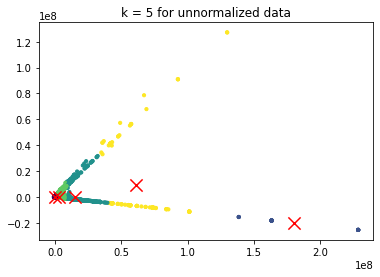

In [31]:
pca = PCA(n_components=3) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data_notnorm = pca.fit_transform(data_num) # storing unnormalized data transformed with pca

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data_notnorm) # fit unnormalized data

plt.scatter(pca_data_notnorm[:, 0], pca_data_notnorm[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for unnormalized data')

Using sklearn.preprocessing functions, we preprocess the data. We use two approaches since the high dimensionality of our data leads to little separation possibility between customers. 

In [32]:
# import ScalerClasses from sklearn.preprocessing
stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
minmaxScaler = MinMaxScaler()
maxScaler = MaxAbsScaler()
powerScaler = PowerTransformer()
robScaler = RobustScaler()
normScaler = Normalizer()

### 1. Approach
In a first approach we the data parameters were scaled with different scalers implemented in sklearn. In a trial and error approach the goal was to obtain some separation of data points over the space of the first two principal components, guided by the standard deviations of the parameters. We try to reduce the variability of features that we term less indicatory, for example min_ratio (min ratio of transaction amount to account balance ) whereas we would want to set larger focus on the age of the bank account users.

In [36]:
cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'trans_greater_100', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance',  '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio','mean_diff',]
cols_for_norm = [ 'max_ratio','mean_ratio', 'min_trans','mean_diff', 'diff_balance', 'mean_age_trans', 'min_balance', ]

In [37]:
data_norm = data_num.copy() # 

data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
data_norm[cols_for_fct_scaling] = fctScaler.transform(data_norm[cols_for_fct_scaling])
data_norm[cols_for_pow_scaling] = powerScaler.fit_transform(data_norm[cols_for_pow_scaling])
data_norm[cols_for_norm] = normalize(data_norm[cols_for_norm])

In [38]:
data_norm.head()

,min_trans,max_trans,trans_greater_1k,balance_greater_100k,0.75_quant_trans,0.25_quant_trans,trans_val_var,min_balance,max_balance,diff_balance,...,nr_diff_dob,mean_age_trans,mean_ratio,max_ratio,nr_trans,trans_greater_100,mean_trans,mean_balance,mean_diff,gender_most_freq
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,-0.015200,0.469705,2.0,2.0,8.203167,7.283105,1.0,0.999255,11.696759,0.012369,...,2,-0.029781,-0.014714,-0.000744,2,1.906793,7.845416,11.242974,0.001134,0
C1010012,0.003568,-0.020811,1.0,1.0,7.313220,7.313220,1.0,0.994686,10.094335,-0.006337,...,1,-0.099152,-0.023833,-0.000761,1,0.102428,7.313220,10.094335,-0.012126,1
C1010014,-0.016632,-0.065171,2.0,2.0,6.874457,6.193895,1.0,0.997237,11.994424,0.019590,...,2,-0.040222,-0.056508,-0.000730,2,1.906793,6.590988,11.514064,0.006837,0
C1010018,-0.034177,-0.242457,0.0,1.0,3.433987,3.433987,1.0,0.994246,6.208952,-0.010298,...,1,-0.086763,-0.040427,-0.001236,1,-1.701937,3.433987,6.208952,-0.032212,0
C1010024,0.054237,0.507426,1.0,1.0,8.517393,8.517393,1.0,0.977403,11.374349,-0.005526,...,1,0.202848,-0.023589,-0.000664,1,0.102428,8.517393,11.374349,0.002725,1


In [ ]:
'''
# TODO these are combinations i tried, all quite bad !
cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']


cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans','mean_ratio' ,'mean_trans', 'mean_balance','TransactionAmount_INR',  'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans']
cols_fro_minmax_scaling = ['min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']

cols_for_std_scaling = [ 'TransactionAmount_INR',  'diff_balance', ]
cols_for_fct_scaling = [ 'min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_trans', 'mean_balance', 'mean_diff','mean_ratio','mean_age_trans']
cols_for_pow_scaling = [  'max_ratio']


cols_for_std_scaling = ['0.75_quant_trans', '0.25_quant_trans',  'diff_balance', 'mean_diff',  'trans_val_var', 'mean_ratio']
cols_for_fct_scaling = [ 'mean_trans', 'mean_balance', 'TransactionAmount_INR','min_trans', 'max_trans', 'min_balance','mean_age_trans' ]
#cols_for_rob_scaling = ['TransactionAmount_INR',  'diff_balance',]
cols_for_norm_scaling = ['mean_ratio', 'diff_balance', 'mean_diff', 'max_ratio'] 
cols_for_max_scaling = [ 'max_balance','max_ratio', ]


# TODO: former combinations !select better option
stdScaler = StandardScaler()
fctScaler = FunctionTransformer(np.log1p)
minmaxScaler = MinMaxScaler()
powerScaler = PowerTransformer() #  diffbalsnce!

cols_for_std_scaling = [ 'TransactionAmount_INR', 'mean_balance', 'mean_diff', 'diff_balance']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans', 'mean_ratio']
cols_for_pow_scaling = []
cols_for_minmax_scaling = ['min_trans', 'max_trans', 'max_ratio','min_balance', 'max_balance','mean_trans'] #'mean_age_trans'



cols_for_std_scaling = [ 'max_ratio','min_trans', 'max_trans', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff', 'diff_balance', 'mean_age_trans']
cols_for_fct_scaling = [ '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']
cols_for_pow_scaling = ['mean_ratio']



cols_for_std_scaling = [ 'diff_balance', 'mean_ratio', 'max_ratio', 'TransactionAmount_INR', 'mean_trans', 'mean_balance', 'mean_diff']
cols_for_fct_scaling = ['min_trans', 'max_trans', '0.75_quant_trans', '0.25_quant_trans','min_balance', 'max_balance']


'''

For the normalized data we conduct the same illustration as for the unnormalized data: Do a principal component analysis with n_components = 3 and cluster the data with k = 5 centroids.

Text(0.5, 1.0, 'k = 5 for normalized data')

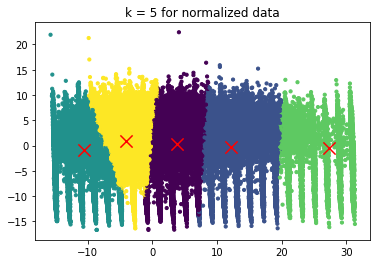

In [39]:
pca = PCA(n_components=0.85) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for normalized data')

### 2. Approach
In a second approach we preselect the features we want to focus on. After plotting a heatmap and distinguishing features with very high correlation, we select only one parameter out of parameters, if their correlation is larger than 0.80. <br />
By following this approach we drop features that, for most customers, contain the same information. For example if a customer does only one transaction, the mean, max, min etc. transaction values would all be the same. We end up with 12 parameters that we scale with the sklearn functions.

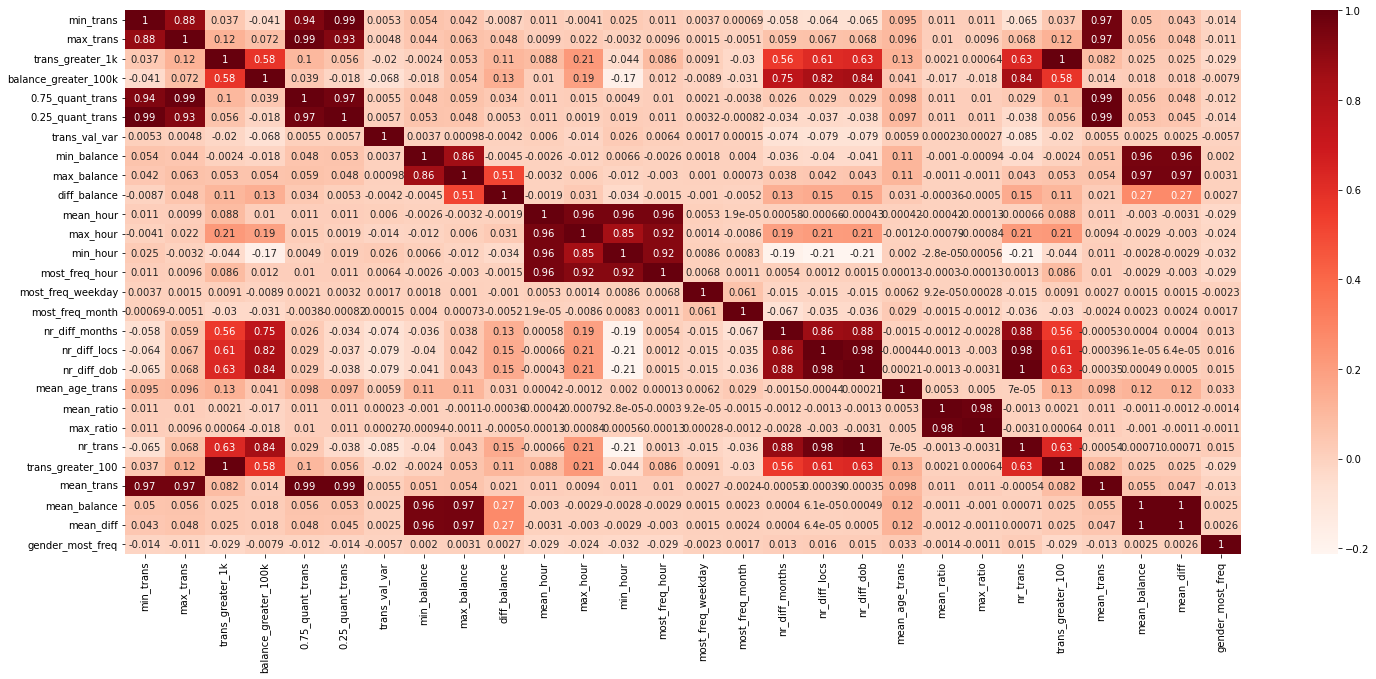

In [40]:
import seaborn as sns

plt.figure(figsize=(25,10))
cor = data_num.corr() # calculate correlation for parameters
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) # plot a heat map
plt.show()

In [44]:
#selecting columns
cols_data_num_sel = ['mean_trans', 'balance_greater_100k','trans_val_var', 'most_freq_hour', 'most_freq_weekday', 'most_freq_month', 'nr_diff_dob', 'mean_age_trans', 'mean_ratio', 'nr_trans', 'mean_balance', 'gender_most_freq']
data_num_sel = data_num[cols_data_num_sel]

In [77]:
cols_for_std_scaling = [ 'mean_age_trans', 'nr_trans', 'nr_diff_dob']
#cols_for_pow_scaling = ['mean_ratio']
cols_for_norm = [ 'mean_trans', 'balance_greater_100k','trans_val_var', 'mean_age_trans', 'mean_ratio', 'mean_balance' ]

In [78]:
data_norm = data_num_sel.copy() # creating a new dataframe data_norm, to be updated with scaled values 

data_norm[cols_for_std_scaling] = stdScaler.fit_transform(data_norm[cols_for_std_scaling])
#data_norm[cols_for_pow_scaling] = powerScaler.fit_transform(data_norm[cols_for_pow_scaling])
data_norm[cols_for_norm] = normalize(data_norm[cols_for_norm])

Transforming the data by a PCA with n_components set to 3 and doing kmeans clustering with n_clusters = 5, we obtain data points with larger distances. We use this normalized form of the data for further analysis.

Text(0.5, 1.0, 'k = 5 for normalized data')

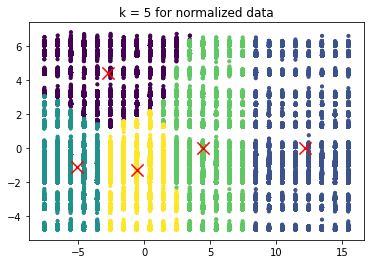

In [80]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_norm)

kmeans = KMeans(n_clusters=5, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('k = 5 for normalized data')

### Dimensionality Reduction
The dimensionality is reduced using sklearns PCA method. The number of dimensions is chosen such that > 85 % of the total data variance is retained.

In [81]:
pca = PCA(n_components=0.85) # by setting n_components to float in [0,1] sklearn estimates the nr of dimension to keep
pca_data = pca.fit_transform(data_norm) # back to data_num from data_norm because kmeans says 0 vectors, no! my fault
print(pca_data.shape)

sparse_pca_data = csr_matrix(pca_data)

(839081, 3)


In [82]:
pca_data.var()
pca.explained_variance_

array([26.27351539,  7.0350572 ,  3.90809082])

The dataset is reduced to 3 dimensions, which makes computation much more feasible. <br />
<br />
The features variances define how strongly they're represented in the pca output, resulting for a weighting by importance.<br />
<br />
There is always some risk of loosing valuable information when focusing only on the parameters of high variance. Additionally the variance of our data will strongly depend on the normalization previously conducted on it, a factor by which we bias the output. <br />
<br />
By introducing a new set of dimensions, the datas space can no longer be interpreted to correspond with the original data parameters.

## 2.3 Clustering!

In [89]:
## matteos first implementation, with mapping and reducing 
# TODO: improve first part

def findNearCentroid(row): # map
    dist = np.sum((centroids_hist[iter]-data[row])**2, axis=1)
    closest = np.argmin(dist)
    return(closest,row) # opposite wont work


def makeNewCentroids(assigned): #shuffle in sense that all centroids are grouped together and reduce by calculating new centroids from data
    shuffled = {}
    #fill_dict =  lambda k, v : shuffled.setdefault(k, []).append(v)
    #map(lambda x: fill_dict(x[0],x[1]), assigned)
    for e in assigned:
        try:
            shuffled[e[0]].append(e[1])
        except:
            shuffled[e[0]] = [e[1]]

    centroids = map( lambda rows: np.mean(data[rows], axis = 0), shuffled.values())
    new_centroids = np.array(list(centroids))
    return (shuffled, new_centroids)

    

def kmeans(k, data, maxIter):
    centroids = np.random.randint(0, data.shape[0], k)
    
    global centroids_hist
    centroids_hist = np.zeros((maxIter+1, k, data.shape[1]), dtype=float)
    centroids_hist[0]= data[centroids]

    rows = np.arange(0, data.shape[0])

    global iter 
    iter = 0

    converge = False

    while tqdm(iter < maxIter and not converge):
        centroids = centroids_hist[iter]
        assigned = map(findNearCentroid, rows) # mapping
        # cp_assigned = [el for el in assigned] # cant copy or modify map object 'assigned' or is empty when passed to makeNewCentoids
        # so access in 

        shuffled, new_centroids = makeNewCentroids(assigned) # shuffling and reducing
        centroids_hist[iter+1] = new_centroids ## fails at times

        if iter > 0 and np.array_equal(centroids_hist[iter],centroids_hist[iter+1]):
             converge = True
             
        iter +=1

    return centroids_hist, shuffled


### Optimal Number of Clusters 
We run the clustering algorithm with n_clusters set in the range [1,10]

#### Elbow Method
Plotting the sum of square distances of data to closest centroid versus the number of centroids.

In [84]:
var = []
for i in range(1,10):
    kmeans_t = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, copy_x=True, algorithm='auto')
    kmeans_t.fit(sparse_pca_data)
    var.append(kmeans_t.inertia_)

Text(0.5, 1.0, 'Elbow method for ideal # clusters')

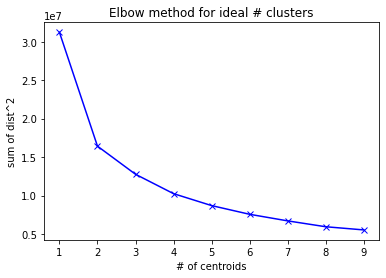

In [85]:
plt.plot(np.arange(1,10), var, 'bx-')
plt.xlabel('# of centroids')
plt.ylabel('sum of dist^2')
plt.title('Elbow method for ideal # clusters')

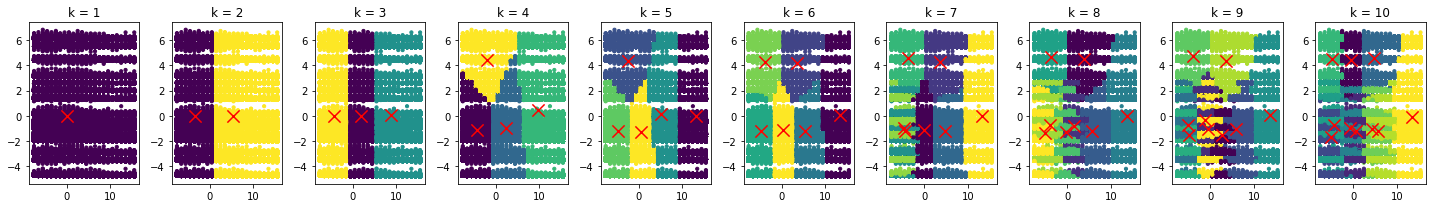

In [86]:

fig,ax = plt.subplots(1,10, figsize = (20,3))

for i in range(1,11):
    kmeans_t = KMeans(n_clusters=i, init='random', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
    kmeans_t.fit(sparse_pca_data)

    cmap = plt.cm.get_cmap('jet', i)

    ax[i-1].scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans_t.labels_.astype(float))

    centroids = kmeans_t.cluster_centers_
    ax[i-1].scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
    ax[i-1].set_title('k = '+str(i))

fig.tight_layout()

The elbow method indicates that the ideal number of clusters is around 2, with a stretch one might consider 3.
Given the above plot we can not clearly state the ideal number of clusters, there's some more interesting splitting when moving from k=6 to k=7.

### Run the Algorithm
We run our algorithm with k=2 and 25 iterations. The data has shape (839081, 3) and one iteration takes around 10 seconds.

In [90]:
data  = pca_data # 
out = kmeans(2, data, 25)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [91]:
# for each data row (customerID) get cluster centroid, used to plot colors

d = out[1] # dictionary of clusterID : [data rows]
cols = []
for k,v in d.items():
    for x in v:
        cols.append([x,k])

cols = np.array(cols)
cols = cols[cols[:, 0].argsort()][:,1]

# centroids of the last iteration
centroids = out[0][3] 


Text(0.5, 1.0, 'K-means with k = 5')

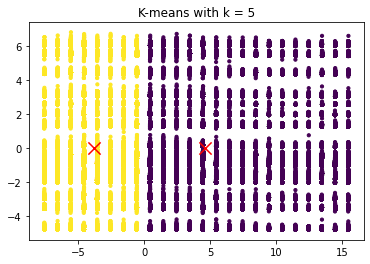

In [92]:
plt.scatter(data[:, 0], data[:, 1], s=10, c = cols)

plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means with k = 5')

### KMeans with scikit-learn Library

Text(0.5, 1.0, 'K-means++ with k = 5')

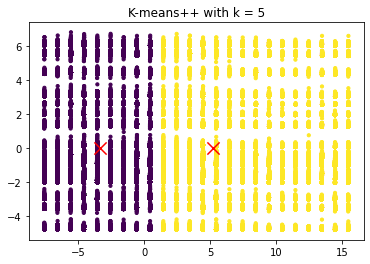

In [93]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=3, max_iter=300, tol=0.0001,random_state=None, algorithm='auto')
kmeans.fit(pca_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=10, c = kmeans.labels_.astype(float))

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],centroids[:, 1],marker="x",s=150, c='red')
plt.title('K-means++ with k = 5')

K-means++ clusters similar to our K-means algorithm. There's visibly a slight shifting of cluster centers in the 'purple cluster' but we can not assert this to a difference in the algorithms, since we only run 25 iterations on our algorithms and up to 300 with sklearns k-means++.

## 2.4 Analysing your results!

In [94]:
import math
# function takes a column of the numerical dataframe data_num
# cols is an array of cluster_indexes for each row, as returned by our kmeans algorithm

def make_bins_pv (columns, cols) -> pd.DataFrame:
    mn = min(columns)
    mx = math.ceil(max(columns))
    bins = np.arange(mn, mx, math.ceil((mx-mn)/4) ) # make bins using min, max values of features
    bins = np.append(bins, mx) # append max value to ensure correct format
    cut = pd.cut(x=columns, bins=bins) # categorising data into bins, returns series
    dumm = pd.get_dummies(cut) # make column out of each category
    pv = pd.pivot_table(dumm, index = cols) # build pivot table
    pv.index.name = 'Cluster'
    return pv

### Pivot Tables

In [ ]:
'mean_trans', 'balance_greater_100k','trans_val_var', 'most_freq_hour', 'most_freq_weekday', 'most_freq_month', 'nr_diff_dob', 'mean_age_trans', 'mean_ratio', 'nr_trans', 'mean_balance', 'gender_most_freq']


In [95]:
col = data_num['mean_trans']
mean_trans = make_bins_pv(col, cols)
mean_trans.style.set_caption('Mean Transaction')

,"(0.0, 390009.0]","(390009.0, 780018.0]","(780018.0, 1170027.0]","(1170027.0, 1560035.0]"
Cluster,,,,
0,0.998825,0.000021,0.000000,0.000003
1,0.999793,0.000022,0.000002,0.000002


In [17]:

col = data_num['trans_greater_1k']
trans_greater_1k = make_bins_pv(col, cols)
trans_greater_1k.style.set_caption('Number of Transactions greater than 1K')

,"(0.0, 2.0]","(2.0, 4.0]","(4.0, 6.0]"
Cluster,,,
0,0.773497,0.008461,0.000040
1,0.846243,0.011250,0.000062


In [18]:

col = data_num['most_freq_hour']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Most Frequent Hour of Transaction')


,"(0, 6]","(6, 12]","(12, 18]","(18, 23]"
Cluster,,,,
0,0.091644,0.540128,0.317932,0.006189
1,0.000000,0.007492,0.434278,0.558230


In [19]:
col = data_num['mean_balance']
most_freq_hour = make_bins_pv(col, cols)
most_freq_hour.style.set_caption('Mean Balance')

,"(0.0, 28758874.0]","(28758874.0, 57517748.0]","(57517748.0, 86276622.0]","(86276622.0, 115035496.0]"
Cluster,,,,
0,0.998094,0.000105,0.000031,0.000006
1,0.998124,0.000064,0.000019,0.000012


In [20]:

col = data_num['gender_most_freq']
dumm = pd.get_dummies(col)
pv = pd.pivot_table(dumm, index = cols)
pv.index.name = 'Cluster'
pv.style.set_caption('Most Frequent Gender')

,0,1
Cluster,,
0,0.255508,0.744492
1,0.287970,0.712030


In [21]:

col = data_num['mean_age_trans']
mean_age_trans = make_bins_pv(col, cols)
mean_age_trans.style.set_caption('Mean Age at Transaction')

,"(15.0, 40.0]","(40.0, 65.0]","(65.0, 90.0]","(90.0, 115.0]"
Cluster,,,,
0,0.886273,0.105808,0.007245,0.000567
1,0.895163,0.099369,0.004818,0.000577


### Clustering score Metrics 

In [23]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [24]:
calinski_harabasz_score = calinski_harabasz_score(pca_data, cols)
calinski_harabasz_score

1020249.1008498162

Calinski Harabasz Score = 1020249.1 
The ratio between intracluster disperion and intercluster dispersion.

In [25]:
davies_bouldin_score = davies_bouldin_score(pca_data, cols)
davies_bouldin_score


0.7981477454174393

Davies Bouldin Score = 0.798
The ratio of intracluster distance to intercluster distance is a value within the range (0,1).
<br />
<br />
The high scores are in accordance to what we observe when plotting the two PC or look at the pivot tables. The customers don't cluster into distinct groups and the large number of parameters results in one blob of data, hence the distance between any pair of data points is low.
The most frequent hours seems to be only parameter invetigted that shows to be well separated by clustering.
<br />
<br />
We propose that better clustering would mainly require a suitable normalization of features. Additionally more accurate results could be obtained by using a different clustering algorithm.